# Notebook to calculate the global change in stability of missense mutations (and in-frame indels) per protein

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats

### paths

In [2]:
base="../../" 

#Data
dataset_rppa_irls_tcga = os.path.join(base,"data/rppa_matched_irls.tsv.gz")
# Role
role_data = os.path.join(base,"external","gene_MoA.tsv")

output_path_plots = os.path.join(base,"plots/Figure2/")
output_path_plots7 = os.path.join(base,"plots/Figure7/")

### load data

In [3]:
df_data = pd.read_csv(dataset_rppa_irls_tcga,sep="\t")
list_phenotypes = ["Missense_Mutation","In_Frame_Ins","In_Frame_Del"]

### Filter out samples:
 -- High-leve amplifications/deletions
 -- Alterations in upstream E3 ub ligases
 -- Alterations in epitope that desestabilize (Due to impairment of recognition)

In [4]:
df_data = df_data[(df_data["CNA"]<=1)&(df_data["CNA"]>=-1)&(~df_data["Altered_E3_Ligases"])&((df_data["Phenotype"]=="WT")|((df_data["Phenotype"].isin(list_phenotypes))&(~((df_data["Disrupt_Epitope"])&(df_data["Stability_Change"]<0)))))]

### For each protein with enough number of mutations.... (N=10)

In [5]:
N=5
df_muts = df_data[(df_data["Phenotype"]!="WT")].groupby(["Protein"],as_index=False).agg({"Matchable_Sample_ID":"count"})
proteins = df_muts[df_muts["Matchable_Sample_ID"]>=N]["Protein"].unique()

### Perform the calculation

In [6]:
list_values = []
for protein in proteins:
    mt = df_data[(df_data["Protein"]==protein)&(df_data["Phenotype"]!="WT")]["Stability_Change"].values
    wt = df_data[(df_data["Protein"]==protein)&(df_data["Phenotype"]=="WT")]["Stability_Change"].values
    pvalue = stats.mannwhitneyu(mt,wt,alternative="two-sided")[1]
    list_values.append([len(mt),len(wt),np.nanmean(mt),np.nanmean(wt),np.nanmean(mt)-np.nanmean(wt),pvalue,protein])

### Concat the output

In [7]:
df_results = pd.DataFrame(list_values,columns=["Num_MT","Num_WT","Mean_MT","Mean_WT","Diff","pvalue","Protein"])

### Add information of hugo symbol and oncogene/TsG

In [8]:
role_data

'../../external/gene_MoA.tsv'

In [9]:
df_roles = pd.read_csv(role_data,sep="\t")
df_roles["Hugo_Symbol"] = df_roles["gene"]
df_roles["ROLE"] = df_roles["gene_MoA"]

In [10]:
info_proteins = df_data[["Protein","Hugo_Symbol"]].drop_duplicates()
# Include hugo
df_results  = df_results.merge(info_proteins,how="left")
# Include the role
df_results = df_results.merge(df_roles[["Hugo_Symbol","ROLE"]].drop_duplicates(),how="left")
# Fill na
df_results["ROLE"].fillna("Unknown",inplace=True)

In [11]:
df_results[df_results["pvalue"]<0.05].sort_values("Diff")

Num_MT  Num_WT   Mean_MT   Mean_WT      Diff         pvalue  \
92        7    3036 -1.309973  0.020727 -1.330701   1.096251e-02   
133      96    5792 -0.769347  0.063572 -0.832919   4.248610e-06   
110      59     530 -0.458025  0.034375 -0.492400   1.562190e-09   
53      121    6615 -0.197393  0.162462 -0.359855   2.442400e-04   
46       58    6786 -0.337256 -0.005338 -0.331918   1.971588e-04   
102      76    6498 -0.247032  0.060732 -0.307765   1.655754e-02   
62       20    6311 -0.280349  0.020504 -0.300853   4.360937e-02   
93       29    2019 -0.328056 -0.027839 -0.300217   3.306308e-02   
163      93    6550 -0.321630 -0.033848 -0.287783   4.153345e-02   
127      38    6309 -0.268065  0.015998 -0.284064   2.515136e-02   
18      199    6430 -0.287592 -0.027283 -0.260309   4.234699e-06   
116      35    6792 -0.225641  0.031267 -0.256907   5.291689e-03   
137      22    6797 -0.222714 -0.008988 -0.213726   3.281872e-02   
22       85    6627 -0.230884 -0.025981 -0.204903   8.495443e-03   
98      126    6381 -0.142183  0.058488 -0.200671   1.676553e-04   
178      96    6520 -0.169346  0.031167 -0.200512   1.387722e-03   
37       70    6669 -0.128628  0.070552 -0.199180   1.289917e-03   
119      49    6752 -0.203303 -0.005630 -0.197673   3.547696e-02   
120      69    6755 -0.194419 -0.007388 -0.187031   1.950370e-02   
168     134    6073 -0.218820 -0.032230 -0.186590   8.997628e-03   
183      59    6791 -0.155338  0.014321 -0.169659   2.297382e-02   
138      21    6797 -0.189908 -0.020288 -0.169620   3.998195e-02   
27       30    6826 -0.162934  0.003308 -0.166242   4.633687e-02   
32      441    6313 -0.157526 -0.009604 -0.147922   1.610378e-08   
172      86    6567 -0.131487  0.009694 -0.141181   1.718507e-02   
201      69    6308 -0.175517 -0.034778 -0.140739   2.575285e-02   
129      40    6742 -0.121513  0.005751 -0.127264   2.378930e-02   
148      65    6579 -0.074822  0.042794 -0.117616   3.546467e-02   
111      51    6780  0.061703 -0.020445  0.082148   1.279291e-02   
130     167    6251  0.171620  0.024172  0.147448   1.899454e-02   
131     151    6679  0.165143  0.017353  0.147790   3.176065e-02   
79       18    6756  0.147942 -0.019766  0.167708   2.853165e-02   
78       30    6770  0.200513  0.010417  0.190097   4.958246e-02   
132      43     475  0.233302  0.030667  0.202635   1.248322e-02   
128      32    6733  0.218272  0.004066  0.214206   2.545599e-03   
140      27    6711  0.247164  0.017111  0.230053   9.399256e-03   
73       19   13769  0.241823 -0.001040  0.242862   4.631006e-03   
7        50    6587  0.275403  0.030952  0.244452   7.302295e-03   
28      104    6133  0.234799 -0.031511  0.266310   3.691264e-07   
6        50    6587  0.312404  0.021787  0.290616   7.351677e-04   
187      41    6710  0.325087  0.031948  0.293140   1.096445e-02   
100     162    6580  0.367323  0.072209  0.295114   1.386122e-03   
90       19    6716  0.344468  0.005580  0.338887   2.120985e-02   
85       51    6648  0.412036  0.038539  0.373497   1.935461e-02   
117      29    6777  0.462193  0.069767  0.392426   2.518178e-03   
106       6    6650  0.468504  0.009167  0.459338   2.977093e-03   
36       19    6819  0.549478  0.056567  0.492911   1.314056e-02   
70      106    6222  0.581435  0.058955  0.522480   8.939335e-04   
134      14    6582  0.545458  0.021216  0.524243   3.116893e-02   
71      106    6222  0.894485  0.109825  0.784660   1.106709e-05   
103      12    6842  1.033470  0.073808  0.959662   5.322871e-03   
139    1191    4214  1.044899  0.015622  1.029277  2.276106e-157   
61       33    6229  1.449500  0.075706  1.373794   1.591519e-06   

                 Protein Hugo_Symbol       ROLE  
92                 GATA6       GATA6    Unknown  
133             P16INK4A      CDKN2A        LoF  
110                KEAP1       KEAP1        Act  
53                  CMET         MET        Act  
46                  CHK2       CHEK2        LoF  
102    IGF1R_pY1135Y1136       I

### Visualize it

In [12]:
d_roles = {"Act":"#cc0000","ambiguous":"#D4D4D2","Unknown":"#D4D4D2","LoF":"#82CAFA"}
df_results["Color"] = df_results.apply(lambda row: d_roles[row["ROLE"]],axis=1)

### Matplotlib

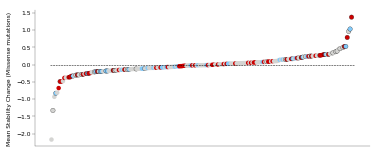

In [13]:
order = [protein+"("+str(n)+")" for protein,n in df_results.sort_values("Diff")[["Protein","Num_MT"]].values]
lw = [0.25 if float(pvalue) < 0.05 else 0.0 for pvalue in df_results.sort_values("Diff")["pvalue"].values]
colors = df_results.sort_values("Diff")["Color"].values
diffs = df_results.sort_values("Diff")["Diff"].values
fig,ax = plt.subplots(figsize=(6,2.5))
xs = range(0,len(order))
ax.scatter(x=xs,y=diffs,color=colors,lw=lw,linestyles="-",edgecolors="black",s=20)
ax.hlines(y=0.0,xmin=-1,xmax=len(order)+1,lw=.5,linestyles="--")
ax.set_xticks(xs)
_=ax.set_xticklabels([],fontsize=6,rotation=90)
ax.set_ylabel("Mean Stability Change (Missense mutations)",fontsize=6)
ax.tick_params(axis = 'y', labelsize =6  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.0 ,width=0.0, size=0.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
plt.savefig(output_path_plots+'/all_genes.pdf', dpi=600,bbox_inches="tight")

### Distribution plot

In [14]:
df_results.shape

(210, 10)

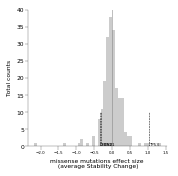

In [15]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
sns.distplot(df_results.Diff.values,ax=ax,color="grey",kde=False,norm_hist=False)
ax.tick_params(axis = 'y', labelsize =6  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
value=df_results[df_results["Hugo_Symbol"]=="CCNE1"]["Diff"].values[0]
ax.axvline(x=value,ymin=0,ymax=0.25,color="black",lw=0.5,ls="--")
ax.annotate(xy=(value,0.25),s="CCNE1",fontsize=4)                                                                    
value=df_results[df_results["Hugo_Symbol"]=="TP53"]["Diff"].values[0]
ax.axvline(x=value,ymin=0,ymax=0.25,color="black",lw=0.5,ls="--")
ax.annotate(xy=(value,0.25),s="TP53",fontsize=4)             
value=df_results[df_results["Hugo_Symbol"]=="CHEK2"]["Diff"].values[0]
ax.axvline(x=value,ymin=0,ymax=0.25,color="black",lw=0.5,ls="--")
ax.annotate(xy=(value,0.25),s="CHEK2",fontsize=4)             
ax.axvline(x=0,ymin=0,ymax=40,lw=0.5,color="grey")
ax.set_xlabel("missense mutations effect size \n (average Stability Change)",fontsize=6)
ax.set_ylabel("Total counts",fontsize=6)
plt.savefig(output_path_plots+'/distribution_all_missense_genes.pdf', dpi=100,bbox_inches="tight")

### Option 3 only significant

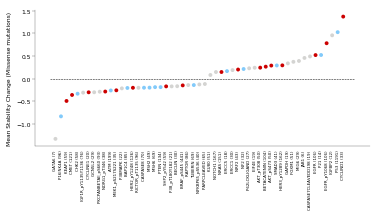

In [16]:
order = [protein+" ("+str(n)+")" for protein,n in df_results[df_results["pvalue"]<0.05].sort_values("Diff")[["Protein","Num_MT"]].values]
lw = [1.0 if float(pvalue) < 0.05 else 0.0 for pvalue in df_results[df_results["pvalue"]<0.05].sort_values("Diff")["pvalue"].values]
colors = df_results[df_results["pvalue"]<0.05].sort_values("Diff")["Color"].values
diffs = df_results[df_results["pvalue"]<0.05].sort_values("Diff")["Diff"].values
fig,ax = plt.subplots(figsize=(6,2.5))
xs = range(0,len(order))
ax.scatter(x=xs,y=diffs,color=colors,lw=0,linestyles="-",edgecolors="black",s=15,label=colors)
ax.hlines(y=0.0,xmin=-1,xmax=len(order)+1,lw=.5,linestyles="--")
ax.set_xticks(xs)
_=ax.set_xticklabels(order,fontsize=10,rotation=90)
ax.tick_params(axis = 'y', labelsize =6  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.0)
ax.set_ylabel("Mean Stability Change (Missense mutations)",fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
plt.savefig(output_path_plots+'/significant_all.pdf', dpi=100,bbox_inches="tight")

### Only oncogenes increase

In [17]:
from matplotlib import collections  as mc

In [18]:
degron = ["NRF2","CYCLIND1","BETACATENIN"]
denovo = ["HER3_pY1289"]
def set_color(row):
    if row["Protein"] in degron:
        return "#ac3973"
    elif row["Protein"] in denovo:
        return "#d98cb3"
    else:
        return "#cc0000"
df_results["Color2"] = df_results.apply(lambda row: set_color(row),axis=1  )

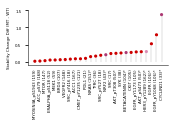

In [19]:
order = [protein+" ("+str(n)+")" for protein,n in df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")[["Protein","Num_MT"]].values]
lw = [0.0 if float(pvalue) < 0.05 else 0.0 for pvalue in df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")["pvalue"].values]
ed = ["black" if float(pvalue) < 0.05 else "white" for pvalue in df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")["pvalue"].values]
colors = df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")["Color2"].values
diffs = df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")["Diff"].values
pvals = df_results[(df_results["ROLE"]=="Act")&(df_results["Diff"]>0)].sort_values("Diff")["pvalue"].values
fig,ax = plt.subplots(figsize=(2.5,1.0))
xs = range(0,len(order))
ax.scatter(x=xs,y=diffs,color=colors,lw=lw,linestyles="-",edgecolors=ed,s=10,label=colors)
lines = []
for i in xs:
    lines.append([(i,0),(i,diffs[i]-0.05)])
lc = mc.LineCollection(lines, colors="grey", linewidths=0.25)
ax.set_xticks(xs)
ax.add_collection(lc)
order_labels = [order[i]+"*" +  if pvals[i] < 0.05 else order[i] for i in range(0,len(order))]
_=ax.set_xticklabels(order_labels,fontsize=4,rotation=90)
_=ax.set_yticks(np.arange(0,1.75,0.5))
ax.set_yticklabels(np.arange(0,1.75,0.5),fontsize=4)
ax.set_ylabel("Stability Change Diff (MT - WT)",fontsize=4)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
plt.savefig(output_path_plots7+'/Oncogenes_Increase.pdf', dpi=100,bbox_inches="tight")